In [1]:
import uproot
from tqdm import tqdm

In [2]:
def getMinMax(fname):
    f = uproot.open(fname)
    e = f['Events']
    runs = e['run'].array()
    return int(min(runs)), int(max(runs))

In [9]:
with open("/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/MultiHiggs/analysis/MultiHAnalysis/input/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Run2018C.txt", "r") as fi:
    lines = fi.readlines()
    lines = [line.strip('\n') for line in lines]
    print(len(lines))

57


In [10]:
rmin, rmax = np.array(()), np.array(())
for line in tqdm(lines):
    tmin, tmax = getMinMax(line)
    rmin = np.append(rmin, tmin)
    rmax = np.append(rmax, tmax)
print(f"{int(rmin.min())}-{int(rmax.max())}")

  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 57/57 [10:12<00:00, 10.75s/it]

319337-320065


In [6]:
tree = uproot.open("/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/MultiHiggs/analysis/MultiHAnalysis/output.root:sixBtree")

In [7]:
ak.argsort(tree['jet_btag'].array(), axis=1, ascending=False)[:,0]

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='37 * int64'>

In [37]:
# tree = SixB("/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/cutflow_studies/presel/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root")
tree = SixB("/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2017UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-1000_MY-250_TuneCP5_13TeV-madgraph-pythia8/ntuple.root")

[14:12:28] Loading model:                                          signal.py:113
           /eos/uscms/store/user/srosenzw/weaver/models/exp_sixb_o              
           fficial/feynnet_ranker_6b/20230731_7d266883bbfb88fe4e22              
           6783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/predict_              
           output/2017/NMSSM_XToYHTo6B_MX-1000_MY-250_TuneCP5_13Te              
           V-madgraph-pythia8.root                                              
           Loading                                                 signal.py:121
           Summer2017UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_              
           MX-1000_MY-250_TuneCP5_13TeV-madgraph-pythia8/ntuple.ro              
           ot...                                                                
Running:  ls /eos/uscms/store/user/srosenzw/weaver/models/exp_sixb_official/feynnet_ranker_6b/20230731_7d266883bbfb88fe4e226783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/predict_output/2017


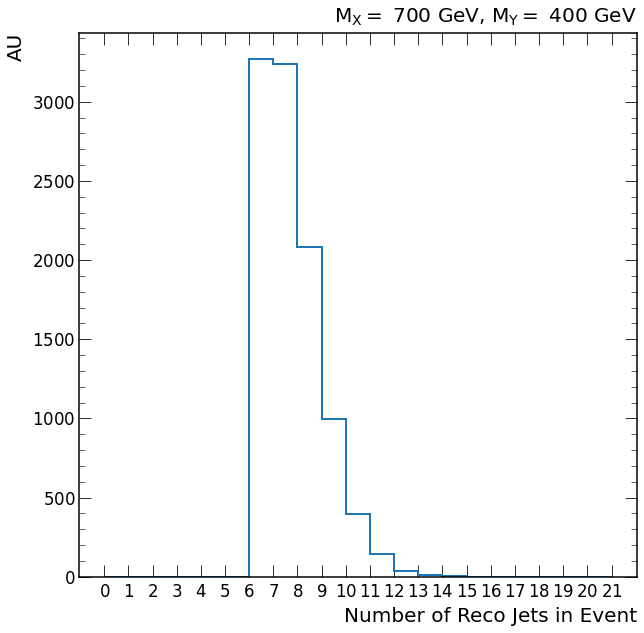

In [8]:
fig, ax = plt.subplots()

tree.hist(tree.n_jet, bins=np.arange(22), ax=ax)
ax.set_xlabel('Number of Reco Jets in Event')

fig.savefig("plots/1_signal_exploration/n_jet.pdf")

In [1]:
import uproot

In [8]:
fout = '/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_28/src/MultiHiggs/analysis/MultiHAnalysis/output.root'
tree = uproot.open(f"{fout}:sixBtree")

In [12]:
tree['matched_quark_eta'].array().to_list(), tree['matched_genjet_eta'].array().to_list()

([[-3.15625], [2.71875], [-1.890625], [2.046875], [-1.08203125], [-3.125]],
 [[-1.254638671875],
  [-0.365966796875],
  [1.6513671875],
  [1.09912109375],
  [-1.515380859375],
  [1.692626953125]])

In [ ]:
import uproot
import subprocess, shlex
fileloc = '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM'
cmd = f"ls {fileloc}/*/fully_res_ntuple.root"
output = subprocess.check_output(shlex.split(cmd))
output = output.decode('utf-8')
output = output.split('\n')
output = [f"{fileloc}/{out}/ntuple.root" for out in output if 'NMSSM' in out]
output

: 

In [21]:
tree = uproot.open("/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_450_2M/output/ntuple_1.root")

[]

In [23]:
tree = sixb_from_gnn(get_NMSSM())

[13:30:10] Loading                                                 signal.py:110
           Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_              
           MX-700_MY-400_TuneCP5_13TeV-madgraph-pythia8/ntuple.roo              
           t...                                                                 
Running:  ls /uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/weaver-multiH/weaver/models/exp_xy/feynnet_6b/20230621_ranger_lr0.0047_batch1024__99_masses_mxmy_reweighting_withbkg/predict_output
[13:30:14] Loading                                                 signal.py:207
           /uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analy              
           sis/CMSSW_10_6_19_patch2/src/sixb/weaver-multiH/weaver/              
           models/exp_xy/feynnet_6b/20230621_ranger_lr0.0047_batch              
           1024__99_masses_mxmy_reweighting_withbkg/predict_output              
           /NMSSM_XToYHTo6B_MX-700_MY

In [6]:
correct_mask = tree.H1_correct & tree.H2_correct

In [22]:
np.sort(tree.scores, axis=1)[:,44]-np.sort(tree.scores, axis=1)[:,43]

array([0.00097656, 0.00390625, 0.04101562, ..., 0.01416016, 0.        ,
       0.00048828], dtype=float32)

array([1.14517570e-01, 1.20243526e+00, 9.67671871e+00, 3.31813622e+01,
       6.35284195e+01, 1.01436157e+02, 1.41504761e+02, 2.10520447e+02,
       3.03372925e+02, 4.24773682e+02, 5.63779053e+02, 6.67517944e+02,
       6.32760986e+02, 4.35814697e+02, 2.51208008e+02, 1.63455566e+02,
       1.29577148e+02, 1.17758301e+02, 1.12680664e+02, 9.95136719e+01,
       9.07641602e+01, 8.13544922e+01, 7.65932617e+01, 7.07124023e+01,
       6.09013672e+01, 5.29267578e+01, 4.94843750e+01, 4.47221680e+01,
       3.85546875e+01, 3.43374023e+01])

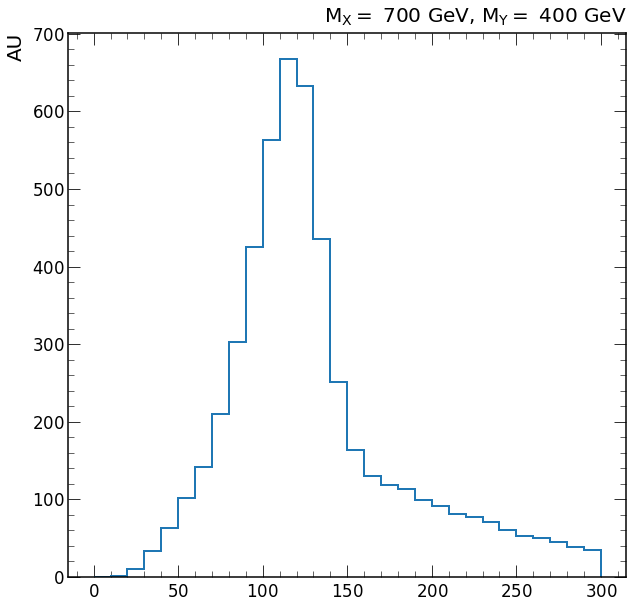

In [26]:
fig, ax = plt.subplots()

tree.hist(tree.HX.m, np.linspace(0,300,31), ax=ax)

array([6.64231539e-01, 1.93151295e-01, 7.91246295e-02, 3.70346308e-02,
       1.51883364e-02, 6.61993027e-03, 2.56031752e-03, 1.15287304e-03,
       4.92572784e-04, 2.59816647e-04, 8.66055489e-05, 5.41806221e-05,
       2.16364861e-05, 1.07884407e-05, 1.08480453e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

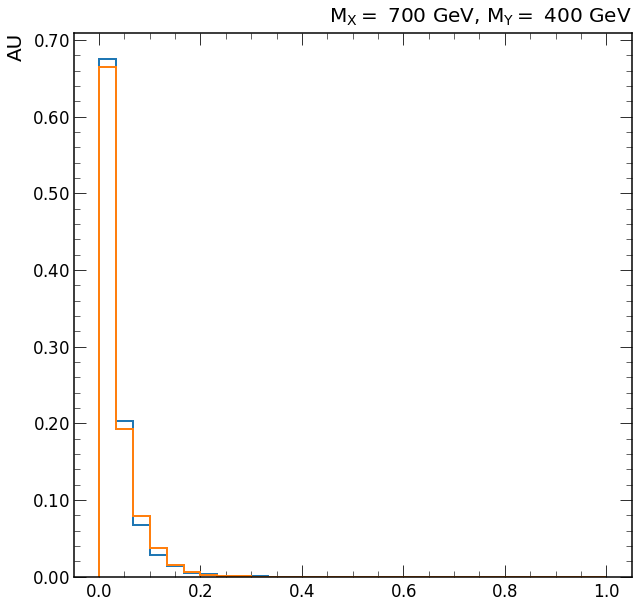

In [25]:
fig, ax = plt.subplots()

tree.hist(tree.max_diff[correct_mask], bins=np.linspace(0,1,31), ax=ax, label='Correct MY', density=True)
tree.hist(tree.max_diff[~correct_mask], bins=np.linspace(0,1,31), ax=ax, label='Incorrect MY', density=True)

In [48]:
max(tree.max_diff)

0.7197265625

Text(0, 1, 'Max Score - Next Highest Score')

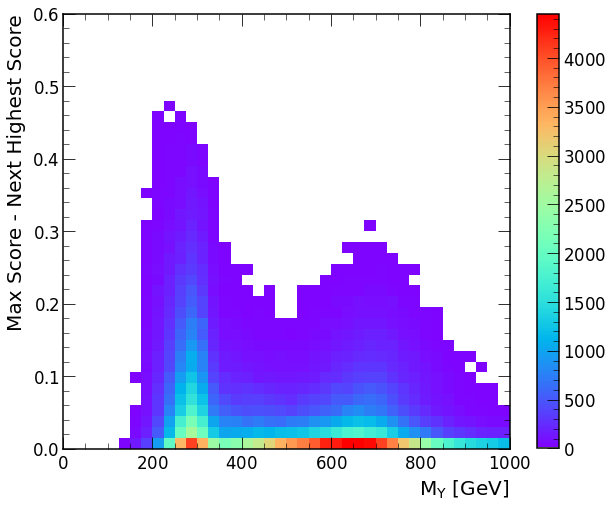

In [49]:
fig, ax = plt.subplots(figsize=(10,8))

n, ex, ey, im = Hist2d(tree.Y.m, tree.max_diff, bins=(np.linspace(0,1000,41), np.linspace(0,0.6,41)), ax=ax)
fig.colorbar(im, ax=ax)

ax.set_xlabel(r'$M_Y$ [GeV]')
ax.set_ylabel('Max Score - Next Highest Score')

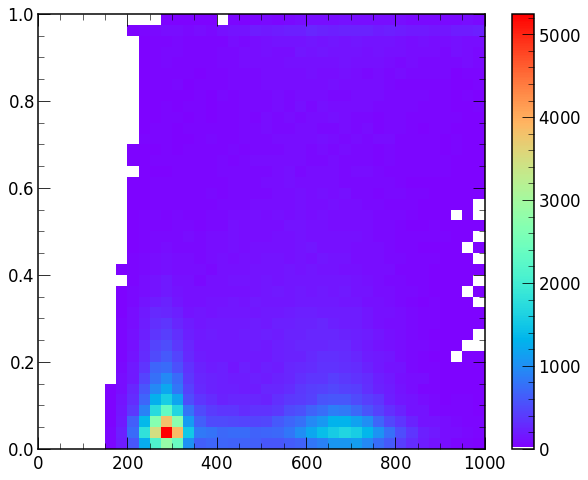

In [46]:
fig, ax = plt.subplots(figsize=(10,8))

n, ex, ey, im = Hist2d(tree.Y.m, tree.minscore, bins=(np.linspace(0,1000,41), np.linspace(0,1,41)), ax=ax)
fig.colorbar(im, ax=ax)

array([0.00000000e+00, 2.13357136e-02, 0.00000000e+00, 2.98699975e-01,
       6.14468718e+00, 4.50608101e+01, 1.60593079e+02, 3.93801331e+02,
       6.54867676e+02, 4.61515381e+02, 2.06001953e+02, 1.74823608e+02,
       1.77701416e+02, 1.80741455e+02, 1.86764893e+02, 1.97424805e+02,
       2.16864258e+02, 2.49548584e+02, 2.82636719e+02, 3.09488281e+02,
       3.15939941e+02, 2.86824219e+02, 2.27139160e+02, 1.72881348e+02,
       1.26226562e+02, 9.05087891e+01, 6.90615234e+01, 5.70786133e+01,
       4.95161133e+01, 4.49663086e+01])

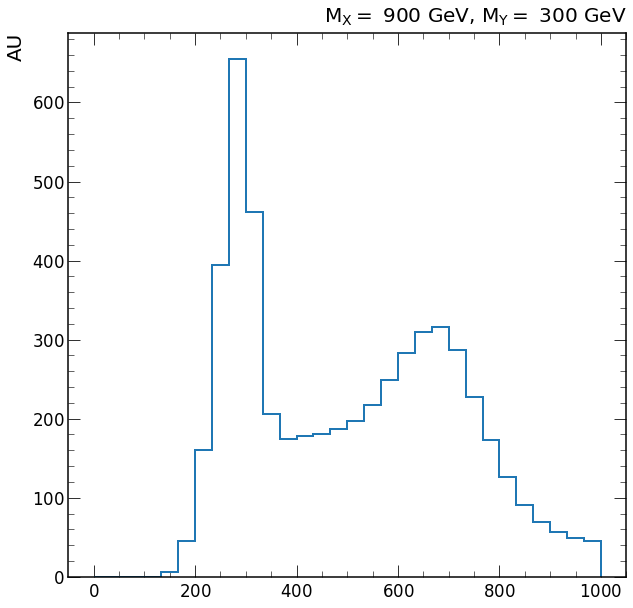

In [41]:
fig, ax = plt.subplots()

tree.hist(tree.Y.m, bins=np.linspace(0,1000,31), ax=ax)

In [37]:
max(tree.max_diff)

0.72021484375

In [12]:
tree.initialize_gen()
tree.gen_matched_HX_b1.deltaR(tree.gen_matched_HX_b2),tree.gen_matched_HX.dr

(<Array [1e+03, 0.832, 0.634, ... 0.697, 998] type='268865 * float32'>,
 <Array [1e+03, 0.832, 0.634, ... 0.697, 998] type='268865 * float32'>)

In [14]:
tree.gen_matched_HX.m[tree.good_mask]

<Array [114, 111, 112, 102, ... 120, 105, 124] type='145763 * float32'>

In [8]:
ak.nan_to_num(tree.gen_matched_HX.m, nan=-1)

<Array [-1, 114, 111, 112, ... 106, 124, -1] type='268865 * float32'>

In [25]:
self.gen_matched_HX

NameError: name 'self' is not defined

In [16]:
type(tree)

utils.analysis.signal.SixB

In [19]:
isinstance(tree, SixB)

False

In [8]:
[key for key in tree.keys() if key.startswith('gen')]

['gen_X_fc_m',
 'gen_X_fc_pt',
 'gen_X_fc_eta',
 'gen_X_fc_phi',
 'gen_X_m',
 'gen_X_pt',
 'gen_X_eta',
 'gen_X_phi',
 'gen_Y_m',
 'gen_Y_pt',
 'gen_Y_eta',
 'gen_Y_phi',
 'gen_HX_m',
 'gen_HX_pt',
 'gen_HX_eta',
 'gen_HX_phi',
 'gen_H1_m',
 'gen_H1_pt',
 'gen_H1_eta',
 'gen_H1_phi',
 'gen_H2_m',
 'gen_H2_pt',
 'gen_H2_eta',
 'gen_H2_phi',
 'gen_HX_b1_m',
 'gen_HX_b1_pt',
 'gen_HX_b1_eta',
 'gen_HX_b1_phi',
 'gen_HX_b2_m',
 'gen_HX_b2_pt',
 'gen_HX_b2_eta',
 'gen_HX_b2_phi',
 'gen_H1_b1_m',
 'gen_H1_b1_pt',
 'gen_H1_b1_eta',
 'gen_H1_b1_phi',
 'gen_H1_b2_m',
 'gen_H1_b2_pt',
 'gen_H1_b2_eta',
 'gen_H1_b2_phi',
 'gen_H2_b1_m',
 'gen_H2_b1_pt',
 'gen_H2_b1_eta',
 'gen_H2_b1_phi',
 'gen_H2_b2_m',
 'gen_H2_b2_pt',
 'gen_H2_b2_eta',
 'gen_H2_b2_phi',
 'gen_HX_b1_genjet_m',
 'gen_HX_b1_genjet_pt',
 'gen_HX_b1_genjet_eta',
 'gen_HX_b1_genjet_phi',
 'gen_HX_b2_genjet_m',
 'gen_HX_b2_genjet_pt',
 'gen_HX_b2_genjet_eta',
 'gen_HX_b2_genjet_phi',
 'gen_H1_b1_genjet_m',
 'gen_H1_b1_genjet_pt',
 'g

In [1]:
from utils.analysis import Signal

Welcome to JupyROOT 6.24/06


In [2]:
indir = f"root://cmseos.fnal.gov//store/user/srosenzw/sixb/ntuples/Summer2018UL/bias/"
datFileName = f"{indir}JetHT_Data_UL/JetHT_Run2018_full/ntuple.root"
datTree = Signal(datFileName)

In [3]:
from configparser import ConfigParser

cfg = 'config/sphereConfig_bias.cfg'

config = ConfigParser()
config.optionxform = str
config.read(cfg)

base = config['file']['base']
data = config['file']['data']

indir = f"root://cmseos.fnal.gov/{base}"
datFileName = f"{indir}{data}"
datTree = Signal(datFileName)
region_type = 'sphere'

variables = config['BDT']['variables']
variables = variables.split(', ')

datTree.spherical_region(config)

VR_center   = 174
SR_edge     = 30
CR_edge     = 40
--------------------



In [4]:
datTree.bdt_process(region_type, config)

.. training BDT in V_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit
.. predicting weights in CR

.. predicting weights in V_SR

.. training BDT in A_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit

.. predicting weights in A_SR



Pull distributions

In [5]:
hs_mask = datTree.V_SRhs_mask
ls_mask = datTree.V_SRls_mask
weights = datTree.V_SR_weights

In [6]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle
from scipy.stats import chisquare

In [7]:
def gauss(x, H, A, x0, sigma):
   return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def kernel_func(X, h, xi):
   A = 1/(h*np.sqrt(2*np.pi))
   B = -0.5*(X-xi)**2/h**2
   return A*np.exp(B)

In [76]:
datTree.keys()

['Run',
 'LumiSec',
 'Event',
 'n_other_pv',
 'rhofastjet_all',
 'X_m',
 'X_pt',
 'X_eta',
 'X_phi',
 'Y_m',
 'Y_pt',
 'Y_eta',
 'Y_phi',
 'HX_m',
 'HX_pt',
 'HX_eta',
 'HX_phi',
 'HY1_m',
 'HY1_pt',
 'HY1_eta',
 'HY1_phi',
 'HY2_m',
 'HY2_pt',
 'HY2_eta',
 'HY2_phi',
 'HX_b1_m',
 'HX_b1_pt',
 'HX_b1_ptRegressed',
 'HX_b1_eta',
 'HX_b1_phi',
 'HX_b1_btag',
 'HX_b2_m',
 'HX_b2_pt',
 'HX_b2_ptRegressed',
 'HX_b2_eta',
 'HX_b2_phi',
 'HX_b2_btag',
 'HY1_b1_m',
 'HY1_b1_pt',
 'HY1_b1_ptRegressed',
 'HY1_b1_eta',
 'HY1_b1_phi',
 'HY1_b1_btag',
 'HY1_b2_m',
 'HY1_b2_pt',
 'HY1_b2_ptRegressed',
 'HY1_b2_eta',
 'HY1_b2_phi',
 'HY1_b2_btag',
 'HY2_b1_m',
 'HY2_b1_pt',
 'HY2_b1_ptRegressed',
 'HY2_b1_eta',
 'HY2_b1_phi',
 'HY2_b1_btag',
 'HY2_b2_m',
 'HY2_b2_pt',
 'HY2_b2_ptRegressed',
 'HY2_b2_eta',
 'HY2_b2_phi',
 'HY2_b2_btag',
 'n_mu_loose',
 'n_ele_loose',
 'mu_1_m',
 'mu_1_pt',
 'mu_1_eta',
 'mu_1_phi',
 'mu_2_m',
 'mu_2_pt',
 'mu_2_eta',
 'mu_2_phi',
 'ele_1_m',
 'ele_1_pt',
 'ele_1_eta',

42.64244946801557 0.27823771741858444


Text(0.99, 0.99, 'mean = 0.126+-0.167\nstd = 0.817+-0.227')

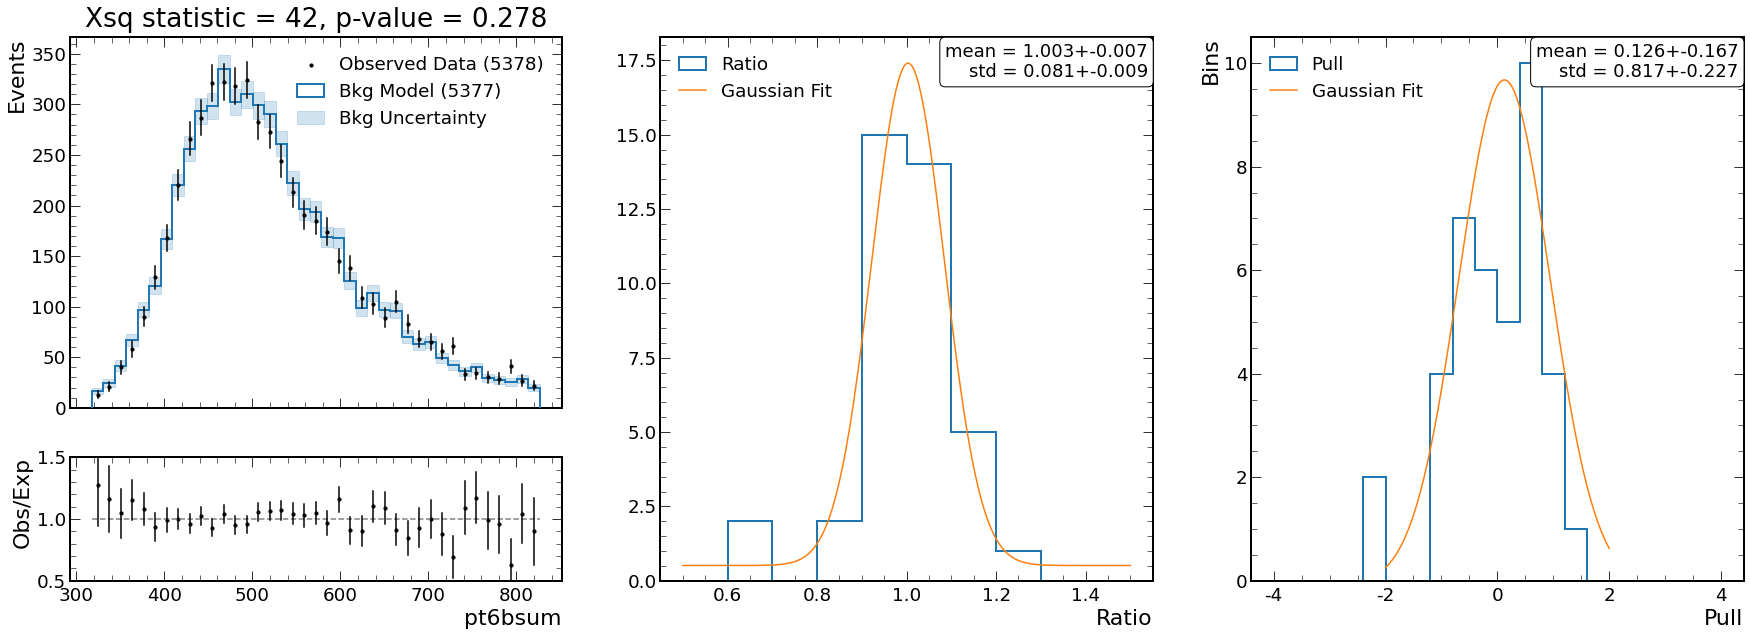

In [111]:
var = variables[0]
original = datTree.np(var)[ls_mask]
target = datTree.np(var)[hs_mask]

nbins = 40
bmin = target.min()
bmax = target.max()
bins = np.linspace(bmin, bmax, nbins)
x = (bins[:-1] + bins[1:]) / 2

n_target, e = np.histogram(target, bins=bins)
bmax = e[:-1][n_target > 0.05*n_target.max()][-1]
bmin = e[:-1][n_target > 0.05*n_target.max()][0]
bins = np.linspace(bmin, bmax, nbins)
x = (bins[:-1] + bins[1:]) / 2

n_target, e = np.histogram(target, bins=bins)

weights = weights * n_target.sum() / weights[(original >= bmin) & (original < bmax)].sum()
n_model, e  = np.histogram(original, bins=bins, weights=weights)
Xsq, p = chisquare(n_target, n_model)
print(Xsq, p)
Xsq, p = int(Xsq), round(p, 3)

fig = plt.figure(figsize=(30,10))
GS = GridSpec(1, 3, figure=fig)

gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=GS[0], height_ratios=[3,1])
gs2 = GridSpecFromSubplotSpec(1, 1, subplot_spec=GS[1])
gs3 = GridSpecFromSubplotSpec(1, 1, subplot_spec=GS[2])

ax1t = fig.add_subplot(gs1[0])
ax1b = fig.add_subplot(gs1[1])
ax2 = fig.add_subplot(gs2[0])
ax3 = fig.add_subplot(gs3[0])

# DISTRIBUTION plots on LEFT axis

ax1t.set_title(f"Xsq statistic = {round(Xsq)}, p-value = {round(p, 3)}")

n_model = Hist(x, weights=n_model, bins=bins, ax=ax1t, zorder=9)
_ = ax1t.plot([x,x],[n_target+np.sqrt(n_target), n_target-np.sqrt(n_target)], color='k', zorder=10)
scatter = ax1t.scatter(x, n_target, s=10, c='k', zorder=10)
handles = [Rectangle([0,0],1,1,color='C0', fill=False, lw=2), Rectangle([0,0],1,1,color='C0', alpha=0.2)]
labels=[f'Bkg Model ({int(n_model.sum())})', 'Bkg Uncertainty']
handles.insert(0,scatter)
labels.insert(0, f'Observed Data ({int(n_target.sum())})')
ax1t.legend(handles=handles, labels=labels)

bin_error_model = np.array(())
for X,n,l in zip(x, n_model, bins):
   width = X - l
   r = X + width
   est_mask = (original >= X - width) & (original < X + width)
   est_err = np.sqrt(np.sum(weights[est_mask]**2))
   bin_error_model = np.append(bin_error_model, np.sum(weights[est_mask]**2))
   ax1t.fill_between([l, r], n-est_err, n+est_err, color='C0', alpha=0.2, zorder=0)

   # est_err_hi = np.where(n == 0, 1 + est_err, (n + est_err) / n)
   # est_err_lo =  np.where(n == 0, 1 - est_err, (n - est_err) / n)
   # ax1b.fill_between([l, r], est_err_lo, est_err_hi, color='C0', alpha=0.2)

ax1t.axes.set_xticklabels([])
ax1t.set_ylabel('Events')

ratio = np.nan_to_num(n_model / n_target, 1)
ratio = np.where(ratio > 10**5, 1, ratio)
ratio = np.where(ratio == 0, 1, ratio)
error = np.sqrt(bin_error_model/n_model**2 + 1/n_target) # 

ax1b.plot([bins[0], bins[-1]], [1, 1], color='grey', linestyle='--')
n_ratio, e = np.histogram(x, weights=ratio, bins=bins)
_ = ax1b.scatter(x, n_ratio, s=10, c='k')
ax1b.plot([x,x],[n_ratio+error,n_ratio-error], color='k')
ax1b.set_xlabel(var)
ax1b.set_ylabel('Obs/Exp')
ax1b.set_ylim(0.5,1.5)

# RATIO plots on MIDDLE axis

rBins = np.arange(0.5,1.5,0.1)
rX = (rBins[:-1] + rBins[1:]) / 2
n_ratio = Hist(ratio, bins=rBins, ax=ax2, label='Ratio')
ax2.set_xlabel('Ratio')

mean = (rX*n_ratio).sum()/n_ratio.sum()
sigma = np.sqrt(sum(n_ratio * (rX-mean) ** 2) / sum(n_ratio))

X = np.linspace(0.5,1.5,200)
params, covar = curve_fit(gauss, rX, n_ratio, p0=[min(n_ratio), max(n_ratio), mean, sigma])
H, A, x0, s = params
y = gauss(X, H, A, x0, s)
std = np.around(np.sqrt(np.diag(covar)),3)

ax2.plot(X, y, label='Gaussian Fit')
ax2.legend(loc=2)
box = {
   'boxstyle' :'round',
   'fc' : 'white'
}
ax2.text(.99,.99,f"mean = {round(x0,3)}+-{std[2]}\nstd = {round(s,3)}+-{std[3]}", transform=ax2.transAxes, bbox=box, fontsize=18, va='top', ha='right')

# PULL plots on RIGHT axis

bins = np.arange(-3,3.0001,0.5)
diff = n_model - n_target
e_diff = np.sqrt(n_target + bin_error_model)
# e_diff = np.sqrt(n_target)
pull = diff / e_diff
n_pull, e = np.histogram(pull, bins=bins)
# N_pull = Hist(pull, bins=np.linspace(-4,4,41), ax=ax3, align='mid', label='Pull')
N_pull = Hist(pull, bins=np.arange(-4,4.0001,0.4), ax=ax3, align='mid', label='Pull')

# x = bins[:-1]
x = (bins[:-1] + bins[1:]) / 2
X = np.linspace(-2,2,200)
# h = 1
# pull_smear = np.zeros_like(X)
# Npull, e = np.histogram(pull, bins=X)
# for xi,n in zip(e[:-1],Npull):
#    if n == 0: continue
#    K = kernel_func(X, h, xi)
#    pull_smear += K
# ax3.plot(X, pull_smear, label='Smeared Pull')

ax3.set_xlabel('Pull')
ax3.set_ylabel('Bins')

mean = (x*n_pull).sum()/n_pull.sum()
sigma = np.sqrt(sum(n_pull * (x-mean) ** 2) / sum(n_pull))

params, covar = curve_fit(gauss, x, n_pull, p0=[min(n_pull), max(n_pull), mean, sigma])
H, A, x0, s = params
y = gauss(X, H, A, x0, s)
std = np.around(np.sqrt(np.diag(covar)),3)

ax3.plot(X, y, label='Gaussian Fit')
ax3.legend(loc=2)
box = {
   'boxstyle' :'round',
   'fc' : 'white'
}
ax3.text(.99,.99,f"mean = {round(x0,3)}+-{std[2]}\nstd = {round(s,3)}+-{std[3]}", transform=ax3.transAxes, bbox=box, fontsize=18, va='top', ha='right')

# x_gauss = np.linspace(-4,4,100)
# y = gauss(x_gauss, 0, 8, 0, 1)
# ax3.plot(x_gauss, y, label='Desired Gaussian')


In [63]:
print(params)
print(covar.round(3))
print(np.sqrt(np.diag(covar)))

[-0.06423866 10.00868545  0.06778254  0.95762637]
[[ 1.173 -0.856  0.    -0.153]
 [-0.856  1.705 -0.     0.043]
 [ 0.    -0.     0.013 -0.   ]
 [-0.153  0.043 -0.     0.033]]
[1.08313995 1.30561585 0.1147617  0.18212764]


In [45]:
%run scripts/bdt_pull_plots.py

['pt6bsum', 'dR6bmin', 'HY1_pt', 'HY2_pt', 'HX_pt', 'HY1_dr', 'HY1_dr', 'HY2_dr', 'HX_dr', 'HX_m', 'HY1_m', 'HY1_HY2_dEta', 'HY2_HX_dEta', 'HX_HY1_dEta', 'HX_HY1_dPhi', 'HY1_HY2_dPhi', 'HY2_HX_dPhi', 'HY1_HY2_dR', 'HX_HY2_dR', 'HX_HY1_dR', 'HY1_costheta', 'HY2_costheta', 'HX_costheta'] 

VR_center   = 174
SR_edge     = 30
CR_edge     = 40
--------------------

.. training BDT in V_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit
.. predicting weights in CR

.. predicting weights in V_SR

.. training BDT in A_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit

.. predicting weights in A_SR

pt6bsum
.. saving fig

dR6bmin
.. saving fig

HY1_pt
.. saving fig

HY2_pt
.. saving fig

HX_pt
.. saving fig

HY1_dr
.. saving fig

HY1_dr
.. saving fig

HY2_dr
.. saving fig

HX_dr
.. saving fig

HX_m
.. saving fig

HY1_m
.. saving fig

HY1_HY2_dEta
.. saving fig

HY2_HX_dEta
.. saving fig

HX_HY1_dE

In [74]:
G_df

,mean,s
pt6bsum,-0.482,0.896
dR6bmin,-0.402,0.958
HY1_pt,-0.204,1.905
HY2_pt,-0.194,0.660
HX_pt,-0.123,1.113
HY1_dr,-0.116,0.897
HY1_dr,-0.099,0.897
HY2_dr,-0.088,0.747
HX_dr,-0.083,0.950
HX_m,-0.072,1.158


In [76]:
import pandas as pd

In [89]:
G = np.column_stack((means, sigmas))
G_df = DataFrame(G, index=variables+['X_m'], columns=['mean', 's'])
G_df

all_df = pd.concat((X_df, G_df), axis=1)
all_df

,Xsq,p,mean,s
HX_m,71.0,0.110,-0.072,1.158
pt6bsum,74.0,0.075,-0.482,0.896
HY1_HY2_dEta,75.0,0.062,-0.052,1.160
HY1_dr,76.0,0.055,-0.116,0.897
HY1_dr,76.0,0.055,-0.099,0.897
HY1_HY2_dPhi,79.0,0.034,0.027,1.067
HX_HY1_dEta,82.0,0.021,0.009,1.031
HY2_HX_dPhi,83.0,0.016,0.036,0.821
HY1_m,87.0,0.007,-0.056,1.065
HY2_HX_dEta,91.0,0.003,0.009,0.754


In [95]:
s_minus_1 = all_df['s'].to_numpy() - 1

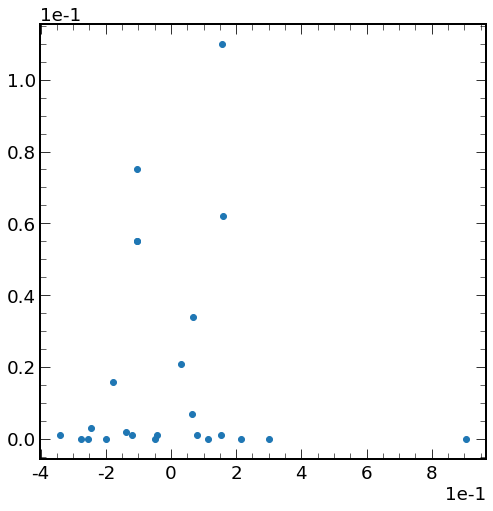

In [97]:
plt.scatter(s_minus_1, p)

In [77]:
from scipy.stats import chi2

0.2715449851181677
52.577404554294915


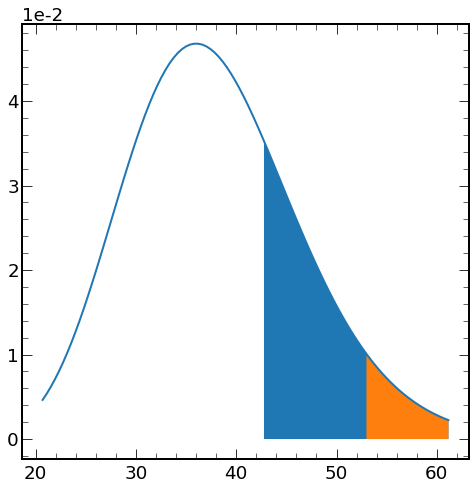

In [127]:
fig, ax = plt.subplots()

df = 38
mean, var, skew, kurt = chi2.stats(df, moments='mvsk')
x = np.linspace(chi2.ppf(0.01, df), chi2.ppf(0.99, df), 100)
y = chi2.pdf(x, df)
ax.plot(x, y, lw=2, label='chi2 pdf')
dx = x[1] - x[0]
stat = 42.64244946801557
ax.fill_between(x[x > stat], chi2.pdf(x[x > stat], df))
print((chi2.pdf(x[x >= stat], df)*dx).sum())
# print(chi2.pdf(x[x > stat], df).sum())
cl_95 = x[y.cumsum()/y.sum() >= 0.95][0]
print(cl_95)
ax.fill_between(x[x > cl_95], y[x > cl_95])